In [18]:
import math
import scipy
import scipy.io
import scipy.signal as s
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=test['Data1']
#f1=f2

f1=np.transpose(f1) #puts data on it's side (easier to work with rows)
f1=f1[::-1]#reverses 
f1 = f1*(10**6) #convert to micro pascals
fs = 500

In [19]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise, parameters come from fdatool

sos=[[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]]

fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
fData=np.asarray(fData)#recast as ndarray


In [20]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

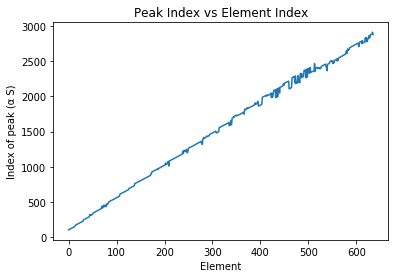

In [21]:
# III. Windowing Around Peak (2s before and after)
peak=[]

#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row)#find peak row[0:10*fs]
    if(peak1<2*fs):#Index too close to begining
        w = row[0:peak1+2*fs]
        DATA = np.concatenate([np.zeros(4*fs-len(w)),w])
    elif(peak1>len(row)-2*fs):#Peak is too close to the end
        w = row[peak1-2*fs:end]
        DATA = np.concatenate([w,np.zeros(4*fs-len(w))])
    else:#peak is sufficient distance from both ends to get a full window
        DATA = row[peak1-2*fs:peak1+2*fs]
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)#recast as ndarray
plt.plot(peak)
plt.title('Peak Index vs Element Index')
plt.xlabel('Element')
plt.ylabel('Index of peak (α S)')
plt.show()


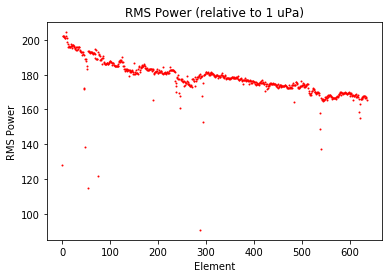

In [29]:
# IV. Calculate RMS of power

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)#recast as ndarray
#print(RMS)
#print(T90)
b = np.linspace(0,len(RMS),len(RMS))
plt.scatter(b,RMS,s=1,c='r')
plt.title('RMS Power (relative to 1 uPa)')
plt.xlabel('Element')
plt.ylabel('RMS Power')
plt.show()

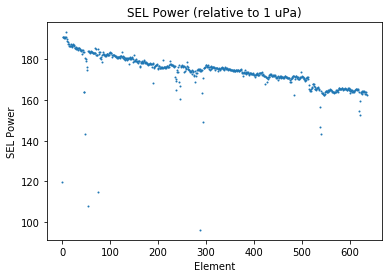

In [30]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1
SEL = np.asarray(SEL)#recast as ndarray
#print(SEL)
plt.scatter(b,SEL,s=1)
plt.title('SEL Power (relative to 1 uPa)')
plt.xlabel('Element')
plt.ylabel('SEL Power')
plt.show()

In [3]:
#V. Remove noisy or inaccurate channels



In [4]:
#VI. Fitting Data
